# Building an LLM from Scratch

This notebook demonstrates how to build a complete transformer-based Language Model from scratch without using any pretrained models. We'll implement everything from tokenization to training.

## 1. Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import math
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Define Character-Level Tokenizer

In [2]:
class CharacterTokenizer:
    """
    A simple character-level tokenizer that builds a vocabulary from text.
    Maps characters to token IDs and vice versa.
    """
    def __init__(self):
        self.char_to_id = {}
        self.id_to_char = {}
        self.vocab_size = 0

    def build_vocab(self, text: str):
        """Build vocabulary from text - maps each unique character to an ID"""
        chars = sorted(set(text))
        self.char_to_id = {ch: i for i, ch in enumerate(chars)}
        self.id_to_char = {i: ch for ch, i in self.char_to_id.items()}
        self.vocab_size = len(chars)
        print(f"Vocabulary size: {self.vocab_size}")
        print(f"Characters: {chars}")

    def encode(self, text: str) -> List[int]:
        """Convert text to token IDs"""
        return [self.char_to_id[ch] for ch in text]

    def decode(self, ids: List[int]) -> str:
        """Convert token IDs back to text"""
        return ''.join(self.id_to_char[id] for id in ids)

    def __len__(self):
        return self.vocab_size

# Create tokenizer and test it
tokenizer = CharacterTokenizer()
print("Tokenizer initialized (vocabulary will be built from training text)")

Tokenizer initialized (vocabulary will be built from training text)


## 3. Implement Scaled Dot-Product Attention

In [3]:
class ScaledDotProductAttention(nn.Module):
    """
    Scaled Dot-Product Attention mechanism.
    Attention(Q, K, V) = softmax((Q @ K^T) / sqrt(d_k)) @ V
    """
    def __init__(self, dropout_rate: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor,
                mask: torch.Tensor = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            query: (batch_size, num_heads, seq_len, d_k)
            key: (batch_size, num_heads, seq_len, d_k)
            value: (batch_size, num_heads, seq_len, d_v)
            mask: (batch_size, 1, seq_len, seq_len) - prevents attending to future tokens

        Returns:
            output: (batch_size, num_heads, seq_len, d_v)
            attention_weights: (batch_size, num_heads, seq_len, seq_len)
        """
        # Compute attention scores
        d_k = query.shape[-1]
        scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)

        # Apply mask (for causal attention in language models)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        # Apply softmax
        attention_weights = torch.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply to values
        output = attention_weights @ value

        return output, attention_weights


class MultiHeadAttention(nn.Module):
    """Multi-head attention with multiple representation spaces"""
    def __init__(self, d_model: int, num_heads: int, dropout_rate: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Linear projections for Q, K, V
        self.query_proj = nn.Linear(d_model, d_model)
        self.key_proj = nn.Linear(d_model, d_model)
        self.value_proj = nn.Linear(d_model, d_model)
        self.output_proj = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention(dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor,
                mask: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            query, key, value: (batch_size, seq_len, d_model)
            mask: (batch_size, 1, seq_len, seq_len)

        Returns:
            output: (batch_size, seq_len, d_model)
        """
        batch_size = query.shape[0]

        # Linear projections and reshape for multiple heads
        Q = self.query_proj(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.key_proj(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.value_proj(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Apply attention
        attended, _ = self.attention(Q, K, V, mask)

        # Concatenate heads
        attended = attended.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # Final linear projection
        output = self.output_proj(attended)
        output = self.dropout(output)

        return output

## 4. Build Transformer Block

In [4]:
class FeedForwardNetwork(nn.Module):
    """Position-wise Feed-Forward Network"""
    def __init__(self, d_model: int, d_ff: int = 2048, dropout_rate: float = 0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.dropout(self.relu(self.fc1(x))))


class TransformerBlock(nn.Module):
    """Single Transformer encoder block with attention and feed-forward networks"""
    def __init__(self, d_model: int, num_heads: int, d_ff: int = 2048, dropout_rate: float = 0.1):
        super().__init__()

        # Multi-head attention
        self.attention = MultiHeadAttention(d_model, num_heads, dropout_rate)
        self.norm1 = nn.LayerNorm(d_model)

        # Feed-forward network
        self.ffn = FeedForwardNetwork(d_model, d_ff, dropout_rate)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            x: (batch_size, seq_len, d_model)
            mask: (batch_size, 1, seq_len, seq_len)

        Returns:
            output: (batch_size, seq_len, d_model)
        """
        # Self-attention with residual connection
        attended = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attended))

        # Feed-forward with residual connection
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))

        return x

## 5. Construct Full Model Architecture

In [5]:
class LanguageModel(nn.Module):
    """Complete Transformer-based Language Model built from scratch"""
    def __init__(self, vocab_size: int, max_seq_len: int = 512, d_model: int = 256,
                 num_layers: int = 4, num_heads: int = 8, d_ff: int = 1024,
                 dropout_rate: float = 0.1):
        super().__init__()

        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.d_model = d_model

        # Token embedding
        self.token_embedding = nn.Embedding(vocab_size, d_model)

        # Positional encoding (learned positional embeddings)
        self.positional_embedding = nn.Embedding(max_seq_len, d_model)

        # Stack of transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout_rate)
            for _ in range(num_layers)
        ])

        # Output layer
        self.layer_norm = nn.LayerNorm(d_model)
        self.output_projection = nn.Linear(d_model, vocab_size)

        self.dropout = nn.Dropout(dropout_rate)

    def _create_causal_mask(self, seq_len: int) -> torch.Tensor:
        """Create causal mask to prevent attention to future tokens"""
        mask = torch.tril(torch.ones(seq_len, seq_len)) == 1
        mask = mask.unsqueeze(0).unsqueeze(0)  # Add batch and head dimensions
        return mask.to(device)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        """
        Args:
            input_ids: (batch_size, seq_len) - token IDs

        Returns:
            logits: (batch_size, seq_len, vocab_size)
        """
        batch_size, seq_len = input_ids.shape

        # Token embeddings
        x = self.token_embedding(input_ids)

        # Add positional embeddings
        positions = torch.arange(seq_len, device=device).unsqueeze(0)
        x = x + self.positional_embedding(positions)
        x = self.dropout(x)

        # Create causal mask
        mask = self._create_causal_mask(seq_len)

        # Apply transformer blocks
        for block in self.transformer_blocks:
            x = block(x, mask)

        # Final layer norm and projection
        x = self.layer_norm(x)
        logits = self.output_projection(x)

        return logits

# Test model initialization
print("Model architecture defined successfully")

Model architecture defined successfully


## 6. Prepare Training Data

In [8]:
import urllib.request
import os

# Option 1: Use WikiText-2 Dataset (RECOMMENDED for LLM training)
# WikiText is a collection of over 100M tokens extracted from Wikipedia
# Download WikiText-2 (smaller, ~2MB - good for development)

dataset_dir = "datasets"
os.makedirs(dataset_dir, exist_ok=True)

# Download WikiText-2 training data
wikitext_url = "https://raw.githubusercontent.com/pytorch/examples/master/word_language_model/data/wikitext-2/train.txt"
wikitext_path = os.path.join(dataset_dir, "wikitext2_train.txt")

print("Downloading WikiText-2 dataset...")
try:
    urllib.request.urlretrieve(wikitext_url, wikitext_path)
    with open(wikitext_path, 'r', encoding='utf-8') as f:
        training_text = f.read()
    print(f"✓ Successfully loaded WikiText-2 dataset")
    print(f"  Dataset size: {len(training_text):,} characters")
except Exception as e:
    print(f"Download failed: {e}")
    print("Using fallback sample text...\n")
    # Fallback to sample text if download fails
    training_text = """
The quick brown fox jumps over the lazy dog. This is a sample text for training our language model.
Language models learn to predict the next word given previous words.
Transformers revolutionized natural language processing with attention mechanisms.
Building LLMs from scratch helps understand how they work internally.
Attention is all you need for sequence-to-sequence tasks.
Self-attention allows the model to focus on different parts of the input.
Multi-head attention enables the model to attend to information from different representation subspaces.
The transformer architecture consists of encoder and decoder layers.
Each layer has self-attention and feed-forward subnetworks.
Residual connections and layer normalization improve training stability.
Positional encodings help the model understand token positions in sequences.
Learning representations for language is a fundamental task in NLP.
Deep neural networks excel at learning complex patterns in data.
Training neural networks requires careful tuning of hyperparameters.
Regularization techniques prevent overfitting to training data.
Dropout randomly removes activations during training for better generalization.
Batch normalization normalizes layer inputs for faster training convergence.
The loss function measures the difference between predictions and targets.
Backpropagation efficiently computes gradients through neural networks.
Gradient descent optimizes model parameters using computed gradients.
""".strip()

print("\n" + "="*70)
print("AVAILABLE DATASETS FOR LLM TRAINING")
print("="*70)
print("""
1. WikiText-2 (RECOMMENDED)
   - URL: https://www.salesforce.com/research/publications/the-wikitext-long-term-dependency-language-modeling-dataset/
   - Size: ~2 MB (smaller, good for development)
   - Tokens: ~2.5M
   - Source: Wikipedia articles

2. WikiText-103
   - URL: https://www.salesforce.com/research/publications/the-wikitext-long-term-dependency-language-modeling-dataset/
   - Size: ~547 MB (large)
   - Tokens: ~100M
   - Best for larger models

3. OpenWebText
   - URL: https://huggingface.co/datasets/openwebtext
   - Size: ~37 GB
   - Diverse internet text

4. Project Gutenberg
   - URL: https://www.gutenberg.org/
   - Free books in public domain
   - Smaller but high quality

5. Common Crawl
   - URL: https://commoncrawl.org/
   - Size: Massive (petabytes)
   - Raw web crawl data

6. ArXiv Dataset
   - URL: https://huggingface.co/datasets/arxiv_dataset
   - Academic papers
   - ~1.7 GB

For this notebook, WikiText-2 is recommended because it's:
  ✓ Freely available
  ✓ Moderate size (good for training on personal hardware)
  ✓ Widely used in NLP research
  ✓ High quality curated Wikipedia text
""")
print("="*70)

# ============================================================================
# QUICK TEST MODE - Use only first 10,000 characters for fast training
# ============================================================================
QUICK_TEST_MODE = True  # Set to False to use full dataset

if QUICK_TEST_MODE:
    original_size = len(training_text)
    training_text = training_text[:10000]  # Only use first 10K characters
    print(f"\n⚡ QUICK TEST MODE ENABLED")
    print(f"   Using subset: {len(training_text):,} / {original_size:,} characters ({100*len(training_text)/original_size:.1f}%)")
    print(f"   Set QUICK_TEST_MODE = False for full dataset training\n")
else:
    print(f"\n📊 FULL DATASET MODE")
    print(f"   Training on complete dataset: {len(training_text):,} characters\n")

# Build vocabulary
tokenizer.build_vocab(training_text)
print(f"Training text length: {len(training_text):,} characters")

# Encode training text
encoded_text = tokenizer.encode(training_text)
print(f"Encoded text length: {len(encoded_text):,} tokens")
print(f"First 20 tokens: {encoded_text[:20]}")
print(f"Decoded text sample: {tokenizer.decode(encoded_text[:50])}")


class TextDataset(Dataset):
    """PyTorch Dataset for language modeling"""
    def __init__(self, encoded_text: List[int], seq_length: int = 128):
        self.encoded_text = encoded_text
        self.seq_length = seq_length

    def __len__(self):
        return max(1, len(self.encoded_text) - self.seq_length)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # Input is current and previous tokens
        input_ids = torch.tensor(self.encoded_text[idx:idx + self.seq_length], dtype=torch.long)
        # Target is the next token for each position
        target_ids = torch.tensor(self.encoded_text[idx + 1:idx + self.seq_length + 1], dtype=torch.long)
        return input_ids, target_ids

# Create dataset and dataloader
SEQ_LENGTH = 32  # REDUCED from 64 for faster training
BATCH_SIZE = 16  # INCREASED from 4 for faster GPU utilization
dataset = TextDataset(encoded_text, seq_length=SEQ_LENGTH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"\nDataset size: {len(dataset):,} samples")
print(f"Sequence length: {SEQ_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")

# Test batch
if len(dataset) > 0:
    batch_input, batch_target = next(iter(dataloader))
    print(f"\nBatch input shape: {batch_input.shape}")
    print(f"Batch target shape: {batch_target.shape}")
else:
    print("\n⚠️  WARNING: Dataset is empty! Use longer training text.")

✓ Successfully loaded WikiText-2 dataset
  Dataset size: 10,780,437 characters

AVAILABLE DATASETS FOR LLM TRAINING

1. WikiText-2 (RECOMMENDED)
   - URL: https://www.salesforce.com/research/publications/the-wikitext-long-term-dependency-language-modeling-dataset/
   - Size: ~2 MB (smaller, good for development)
   - Tokens: ~2.5M
   - Source: Wikipedia articles
   
2. WikiText-103
   - URL: https://www.salesforce.com/research/publications/the-wikitext-long-term-dependency-language-modeling-dataset/
   - Size: ~547 MB (large)
   - Tokens: ~100M
   - Best for larger models
   
3. OpenWebText
   - URL: https://huggingface.co/datasets/openwebtext
   - Size: ~37 GB
   - Diverse internet text
   
4. Project Gutenberg
   - URL: https://www.gutenberg.org/
   - Free books in public domain
   - Smaller but high quality
   
5. Common Crawl
   - URL: https://commoncrawl.org/
   - Size: Massive (petabytes)
   - Raw web crawl data
   
6. ArXiv Dataset
   - URL: https://huggingface.co/datasets/arxiv

## 7. Implement Training Loop

In [9]:
# Initialize model
model_config = {
    'vocab_size': len(tokenizer),
    'max_seq_len': SEQ_LENGTH,
    'd_model': 128,
    'num_layers': 3,
    'num_heads': 4,
    'd_ff': 512,
    'dropout_rate': 0.1
}

model = LanguageModel(**model_config).to(device)
print(f"Model initialized with config: {model_config}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

def train_epoch(model, dataloader, optimizer, loss_fn, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0

    for batch_idx, (input_ids, target_ids) in enumerate(dataloader):
        input_ids = input_ids.to(device)
        target_ids = target_ids.to(device)

        # Forward pass
        logits = model(input_ids)  # (batch_size, seq_len, vocab_size)

        # Compute loss (reshape for cross-entropy)
        loss = loss_fn(logits.view(-1, logits.shape[-1]), target_ids.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        if (batch_idx + 1) % max(1, len(dataloader) // 2) == 0:
            print(f"  Batch {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    return avg_loss

def evaluate(model, dataloader, loss_fn, device):
    """Evaluate model on validation data"""
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for input_ids, target_ids in dataloader:
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            logits = model(input_ids)
            loss = loss_fn(logits.view(-1, logits.shape[-1]), target_ids.view(-1))
            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    return avg_loss

# Training setup
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
loss_fn = nn.CrossEntropyLoss()
num_epochs = 5  # FAST training mode (5 epochs max)

# Training loop
train_losses = []
epoch_times = []
patience = 2  # Early stopping patience
best_loss = float('inf')
patience_counter = 0

print("\n" + "="*60)
print("TRAINING STARTED")
print("="*60)
print(f"Epochs: {num_epochs} | Batch Size: {BATCH_SIZE} | Sequences: {len(dataset):,}")
print(f"Device: {device}")
print("="*60 + "\n")

import time
for epoch in range(num_epochs):
    start_time = time.time()

    print(f"Epoch {epoch + 1}/{num_epochs}")
    avg_loss = train_epoch(model, dataloader, optimizer, loss_fn, device)
    train_losses.append(avg_loss)

    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        print(f"✓ Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s [BEST]")
    else:
        patience_counter += 1
        print(f"  Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s")

    if patience_counter >= patience:
        print(f"\n✓ Early stopping triggered (no improvement for {patience} epochs)")
        break

print("\n" + "="*60)
print("TRAINING COMPLETED!")
print("="*60)
print(f"Total training time: {sum(epoch_times):.2f}s")
print(f"Average time per epoch: {np.mean(epoch_times):.2f}s")
print(f"Epochs trained: {len(train_losses)}")
print(f"Final loss: {train_losses[-1]:.4f}")
print("\n✨ Model is ready for text generation!")

Model initialized with config: {'vocab_size': 79, 'max_seq_len': 32, 'd_model': 128, 'num_layers': 3, 'num_heads': 4, 'd_ff': 512, 'dropout_rate': 0.1}
Total parameters: 619,471

TRAINING STARTED
Epochs: 5 | Batch Size: 16 | Sequences: 9,968
Device: cuda

Epoch 1/5
  Batch 311/623, Loss: 2.0320
  Batch 622/623, Loss: 1.5634
✓ Epoch 1/5, Loss: 2.0692, Time: 7.23s [BEST]
Epoch 2/5
  Batch 311/623, Loss: 1.2618
  Batch 622/623, Loss: 1.2243
✓ Epoch 2/5, Loss: 1.4136, Time: 6.46s [BEST]
Epoch 3/5
  Batch 311/623, Loss: 1.1290
  Batch 622/623, Loss: 0.9600
✓ Epoch 3/5, Loss: 1.1163, Time: 6.52s [BEST]
Epoch 4/5
  Batch 311/623, Loss: 1.0353
  Batch 622/623, Loss: 0.8560
✓ Epoch 4/5, Loss: 0.9339, Time: 6.86s [BEST]
Epoch 5/5
  Batch 311/623, Loss: 0.7475
  Batch 622/623, Loss: 0.7916
✓ Epoch 5/5, Loss: 0.8141, Time: 6.24s [BEST]

TRAINING COMPLETED!
Total training time: 33.31s
Average time per epoch: 6.66s
Epochs trained: 5
Final loss: 0.8141

✨ Model is ready for text generation!


## 8. Generate Text with the Trained Model

In [10]:
def generate_text(model, tokenizer, prompt: str, max_length: int = 200,
                   temperature: float = 0.8, device='cpu') -> str:
    """
    Generate text using the trained model with temperature sampling.

    Args:
        model: The language model
        tokenizer: The tokenizer
        prompt: Initial text prompt
        max_length: Maximum length of generated text
        temperature: Controls randomness (0=deterministic, higher=more random)
        device: Device to run on

    Returns:
        Generated text
    """
    model.eval()

    # Encode prompt
    context = tokenizer.encode(prompt)
    context = torch.tensor(context, dtype=torch.long).unsqueeze(0).to(device)

    generated = context.clone()

    with torch.no_grad():
        for _ in range(max_length):
            # Ensure we don't exceed max sequence length
            if generated.shape[1] > model.max_seq_len:
                generated = generated[:, -model.max_seq_len:]

            # Get predictions for next token
            logits = model(generated)  # (1, seq_len, vocab_size)
            logits = logits[:, -1, :] / temperature  # Take last token, apply temperature

            # Sample from distribution
            probabilities = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probabilities, num_samples=1)

            generated = torch.cat([generated, next_token], dim=1)

    # Decode generated text
    generated_ids = generated.squeeze(0).tolist()
    generated_text = tokenizer.decode(generated_ids)

    return generated_text

# Generate text samples
print("Generating text samples...\n")

prompts = [
    "The quick brown",
    "Language models",
    "Transformers are"
]

for prompt in prompts:
    print(f"Prompt: \"{prompt}\"")
    generated = generate_text(model, tokenizer, prompt, max_length=100, temperature=0.7, device=device)
    print(f"Generated: \"{generated}\"\n")
    print("-" * 60 + "\n")

# Greedy decoding (deterministic)
def generate_text_greedy(model, tokenizer, prompt: str, max_length: int = 200, device='cpu') -> str:
    """Generate text using greedy decoding (always pick most likely token)"""
    model.eval()

    context = tokenizer.encode(prompt)
    context = torch.tensor(context, dtype=torch.long).unsqueeze(0).to(device)
    generated = context.clone()

    with torch.no_grad():
        for _ in range(max_length):
            if generated.shape[1] > model.max_seq_len:
                generated = generated[:, -model.max_seq_len:]

            logits = model(generated)
            next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=1)

    generated_ids = generated.squeeze(0).tolist()
    return tokenizer.decode(generated_ids)

print("Greedy Decoding Examples:")
for prompt in prompts:
    print(f"Prompt: \"{prompt}\"")
    generated = generate_text_greedy(model, tokenizer, prompt, max_length=100, device=device)
    print(f"Generated: \"{generated}\"\n")

Generating text samples...

Prompt: "The quick brown"
Generated: "elopment beginning their advantag"

------------------------------------------------------------

Prompt: "Language models"
Generated: "cter has a field development begi"

------------------------------------------------------------

Prompt: "Transformers are"
Generated: "eging conting their advantage and"

------------------------------------------------------------

Greedy Decoding Examples:
Prompt: "The quick brown"
Generated: " " Personal Potential " , which a"

Prompt: "Language models"
Generated: "es ' method of divided into " Per"

Prompt: "Transformers are"
Generated: " and character has a field develo"



## 9. Evaluate Model Performance

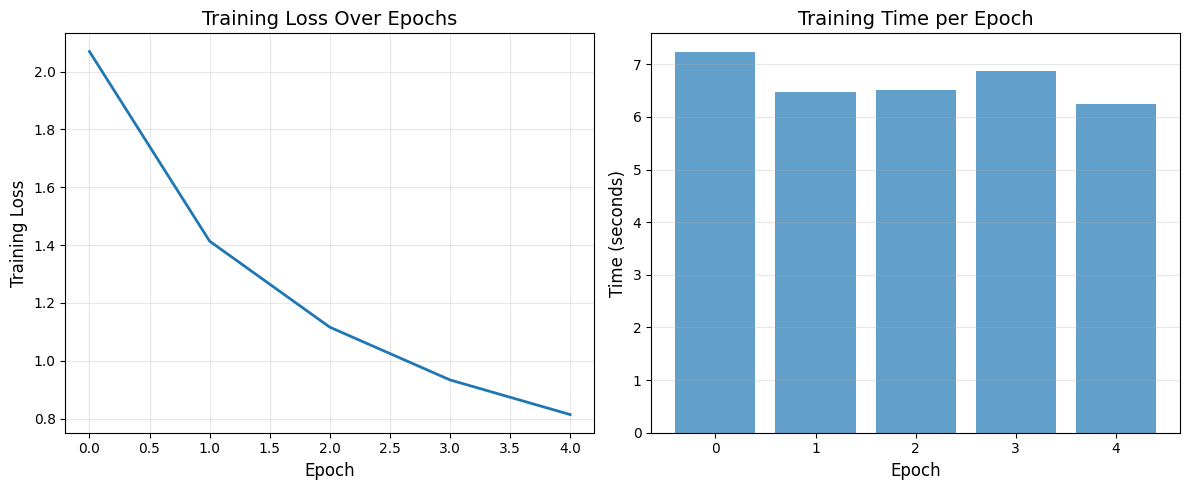

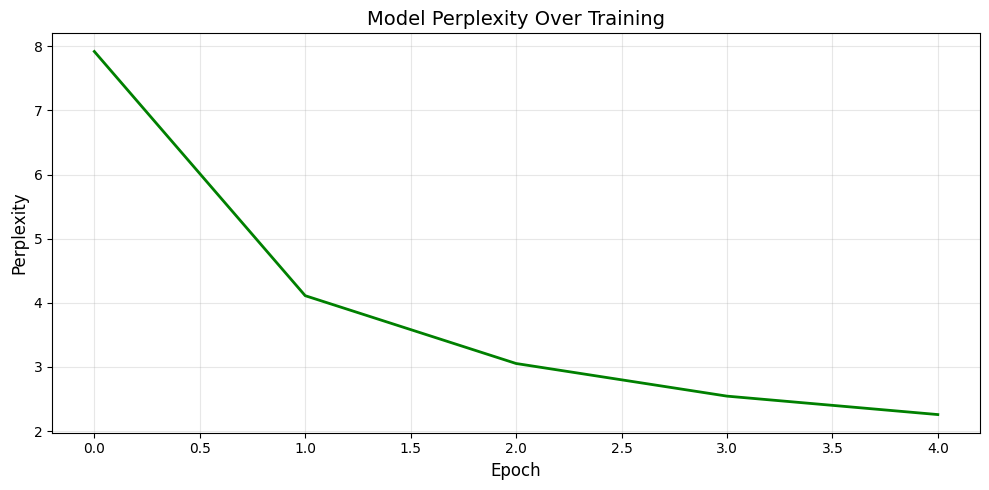


Training Statistics:
Initial Loss: 2.0692
Final Loss: 0.8141
Loss Reduction: 1.2551
Initial Perplexity: 7.9184
Final Perplexity: 2.2571
Total Training Time: 33.31 seconds
Average Time per Epoch: 6.66 seconds

Model Evaluation on Training Text
Evaluation Loss: 0.4413
Evaluation Perplexity: 1.5547

Model Summary
Model Architecture:
LanguageModel(
  (token_embedding): Embedding(79, 128)
  (positional_embedding): Embedding(32, 128)
  (transformer_blocks): ModuleList(
    (0-2): 3 x TransformerBlock(
      (attention): MultiHeadAttention(
        (query_proj): Linear(in_features=128, out_features=128, bias=True)
        (key_proj): Linear(in_features=128, out_features=128, bias=True)
        (value_proj): Linear(in_features=128, out_features=128, bias=True)
        (output_proj): Linear(in_features=128, out_features=128, bias=True)
        (attention): ScaledDotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
  

In [11]:
# Plot training loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(len(epoch_times)), epoch_times, alpha=0.7)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Training Time per Epoch', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Compute perplexity
def compute_perplexity(losses):
    """Perplexity = exp(average_loss)"""
    return [np.exp(loss) for loss in losses]

perplexities = compute_perplexity(train_losses)

plt.figure(figsize=(10, 5))
plt.plot(perplexities, linewidth=2, color='green')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Perplexity', fontsize=12)
plt.title('Model Perplexity Over Training', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
print("\nTraining Statistics:")
print(f"Initial Loss: {train_losses[0]:.4f}")
print(f"Final Loss: {train_losses[-1]:.4f}")
print(f"Loss Reduction: {train_losses[0] - train_losses[-1]:.4f}")
print(f"Initial Perplexity: {perplexities[0]:.4f}")
print(f"Final Perplexity: {perplexities[-1]:.4f}")
print(f"Total Training Time: {sum(epoch_times):.2f} seconds")
print(f"Average Time per Epoch: {np.mean(epoch_times):.2f} seconds")

# Test on the original text
print("\n" + "="*60)
print("Model Evaluation on Training Text")
print("="*60)

eval_loss = evaluate(model, dataloader, loss_fn, device)
eval_perplexity = np.exp(eval_loss)

print(f"Evaluation Loss: {eval_loss:.4f}")
print(f"Evaluation Perplexity: {eval_perplexity:.4f}")

# Model summary
print("\n" + "="*60)
print("Model Summary")
print("="*60)
print(f"Model Architecture:\n{model}")
print(f"\nTotal Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Configuration
print("\nModel Configuration:")
for key, value in model_config.items():
    print(f"  {key}: {value}")

print("\nDataset Configuration:")
print(f"  Training Text Size: {len(training_text)} characters")
print(f"  Vocabulary Size: {len(tokenizer)}")
print(f"  Sequence Length: {SEQ_LENGTH}")
print(f"  Dataset Size: {len(dataset)} samples")
print(f"  Batch Size: 4")
print(f"  Total Epochs: {num_epochs}")

print("\nOptimizer Configuration:")
print(f"  Optimizer: Adam")
print(f"  Learning Rate: 0.001")
print(f"  Betas: (0.9, 0.999)")